# 2950 Project Phase 2

Flavia Jiang (yj472), Rachel Wang (jw879)

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.linear_model import LinearRegression, LogisticRegression
import duckdb

## Research Question

## Data Description

1.What are the observations (rows) and the attributes (columns)?


2. Why was this dataset created?
This dataset was created to investigate and analyze various aspects of human dating behavior in the context of speed dating. 
Researchers were interested in understanding how individuals(males and females) make dating decisions, what attributes they 
consider important, and how different factors influence the outcomes of speed dating encounters.

3. Who funded the creation of the dataset?

The dataset was collected as part of academic research. 

4. What processes might have influenced what data was observed and recorded and what was not?

Participant Demographics: The age, gender, and demographic characteristics of the participants could influence the data collected. 
In this study, all subjects are from graduate and professional school of Columbia University.

Self-Selection of Participants: Participants in the speed dating experiment were volunteers, which means they self-selected to take part. 
This self-selection process may have introduced biases, as those who chose to participate might have different preferences or characteristics 
compared to the general population. This could impact the generalizability of the findings.

Experiment Design: The design of the speed dating experiment determined what data could be collected. The researchers structured the experiment, 
including the number of participants, the number of potential partners, and the available information about each partner. The experimental 
conditions may not fully represent real-world dating situations.

Survey Responses: The data collected was based on surveys and questionnaires filled out by participants. Data collection relied on participants' 
willingness to respond honestly and accurately, which could be influenced by social desirability bias or other factors.

5. What preprocessing was done, and how did the data come to be in the form that you are using?


6. If people are involved, were they aware of the data collection, and if so, what purpose did they expect the data to be used for?

Participants in the speed dating events would have been aware of the data collection process, as informed consent is a standard practice 
in research involving human subjects. They would have been informed about the purpose of the data collection, which is typically for academic 
research. Participants would have expected the data to be used to study dating behavior and potentially contribute to our understanding of human 
interactions and preferences.

7. Where can your raw source data be found, if applicable? Provide a link to the raw data

Link to the dataset and the documentation: http://www.stat.columbia.edu/~gelman/arm/examples/speed.dating/ 


## Data Cleaning

Firstly, load the data.

In [24]:
dating_df = pd.read_csv("speed_dating_data.csv", encoding="ISO-8859-1")
dating_df.shape

(8378, 195)

### Remove unnecessary columns
The data set is super wide, and there are so many variables. So we went through the variable codebook made by the creators of this data set and removed variables we currently think would be definitely unnecessary for our future analysis.

In [25]:
select_list = ['iid', 'gender', 'wave', 'round','pid', 
       'samerace', 'age_o', 'age', 'field_cd', 'race',
       'career_c', 'sports', 'tvsports', 'exercise', 'dining',
       'museums', 'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv',
       'theater', 'movies', 'concerts', 'music', 'shopping', 'yoga', 'attr1_1',
       'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1', 'attr3_1',
       'sinc3_1', 'fun3_1', 'intel3_1', 'amb3_1', 'dec', 'attr', 'sinc',
       'intel', 'fun', 'amb', 'shar', 'prob']

dating_df = dating_df[select_list]
dating_df.shape

(8378, 47)

### Rename columns
Now, we still have many columns. Certainly, we won't use all of them, but we kept them there because they are potential predictors that might help train the model. And we don't want to restrict ourselves to a specific set of variables. 

Though we did not do any web scraping or merge data sets to get this data frame, one main effort we made was to interpret the meaning of each variable -- carefully reading through the 15-paged variable codebook. We noticed that some of the names of the given variable names were vague. So, we decided to change them so they conveyed more straightforward information about the variables. 

In [26]:
dating_df = dating_df.rename(columns = {"iid":"id",
                                        "age_o":"partner_age",
                                        "round": "num_dates", 
                                        "pid": "partner_id", 
                                        "samerace": "same_race"})
dating_df.head()

,id,gender,wave,num_dates,partner_id,same_race,partner_age,age,field_cd,race,...,intel3_1,amb3_1,dec,attr,sinc,intel,fun,amb,shar,prob
0,1,0,1,10,11.0,0,27.0,21.0,1.0,4.0,...,8.0,7.0,1,6.0,9.0,7.0,7.0,6.0,5.0,6.0
1,1,0,1,10,12.0,0,22.0,21.0,1.0,4.0,...,8.0,7.0,1,7.0,8.0,7.0,8.0,5.0,6.0,5.0
2,1,0,1,10,13.0,1,22.0,21.0,1.0,4.0,...,8.0,7.0,1,5.0,8.0,9.0,8.0,5.0,7.0,NaN
3,1,0,1,10,14.0,0,23.0,21.0,1.0,4.0,...,8.0,7.0,1,7.0,6.0,8.0,7.0,6.0,8.0,6.0
4,1,0,1,10,15.0,0,24.0,21.0,1.0,4.0,...,8.0,7.0,1,5.0,6.0,7.0,7.0,6.0,6.0,6.0


### Remove biased data points
As described in Data Description part, the researchers ran 21 speed dating sessions, or waves, in total. However, as they explained in their paper, they removed four sessions (waves 18-21) from the analysis "because they involved an experimental intervention where participants were asked to bring their favorite book. These four sessions were run specifically to study how decision weights and selectivity would be affected by an intervention designed to shift subjects’ attention away from superficial physical attributes. The inclusion of these four sessions does not alter the results reported below; they are omitted so that the only experimental difference across sessions is group size." Accordingly we also removed data for these four sessions. 

The researchers also said they removed another wave (#12) because they "imposed a maximum number of acceptances" on participants of this wave. We thought this restriction would affect participants' decisions, so we also removed this wave.

In [27]:
dating_df = dating_df[~dating_df['wave'].isin([12, 18, 19, 20, 21])]
dating_df.shape

(6412, 47)

The researchers also mentioned they removed two more sessions from their analysis because they thought their participants were too few. We thought this was not a big concern as of now. So we decided to keep them.

We had another concern, which the researchers did not address in their analysis. We noitced that for many of the survey questions, the researchers let participants of waves 6-9 rate the importance of six attributes separately on a scale of 1-10 and let participants of other waves distribute 100 points to these six attributes. Let's investigate this in the dataset with an example involving variables attr1_1, sinc1_1, intel1_1, fun1_1, amb1_1, shar1_1. 

In [28]:
temp = dating_df[(dating_df['wave'] > 5) & (dating_df['wave'] < 10)]
temp[['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']].head()

,attr1_1,sinc1_1,intel1_1,fun1_1,amb1_1,shar1_1
1846,16.67,16.67,16.67,16.67,16.67,16.67
1847,16.67,16.67,16.67,16.67,16.67,16.67
1848,16.67,16.67,16.67,16.67,16.67,16.67
1849,16.67,16.67,16.67,16.67,16.67,16.67
1850,16.67,16.67,16.67,16.67,16.67,16.67


As we could infer from the values, the researchers converted the data for waves 6-9 so that for each set of variables for six attributes, they added up to 100 points. For example, if a participant of wave 6 rated these six attributes all as very important (that is, answered 10s to these six questions), it would be converted to (16.67, 16.67, 16.67, 16.67, 16.67, 16.67) so they summed to 100.

They did this so that they could still include waves 6-9 in the analysis. But this rude conversion could be problemetic. The simple logic is that the participant in the above example might think all six attributes were very important but not equally important. Then the adjusted data was not an accurate representation of the participant's beliefs.

Note that there were many sets of six variables like this because the researchers asked the participants to rate the importance of six attributes in different settings. And we were quite sure we would use at least one set of variable like this. So we decided to remove waves 6-9 from our analysis.

In [29]:
dating_df = dating_df[~dating_df['wave'].isin([6, 7, 8, 9])]
dating_df.shape

(4850, 47)

We know so far we had removed about half of the rows from the dataframe. But we still have 4000+ data points, which from a statistical standpoint are enough for regression and inference.

### Deal with missing values
We noticed for some variables there were many missing values due to how the experiment was designed and conducted. For each variable with missing values, we re-examined whether we still thought it would be a potential good predictor in our future modeling given the fact that including it would make the model less robust. We made decisions between keeping or removing the columns accordingly.

In [30]:
for col in dating_df:
    n = sum(pd.isna(dating_df[col]))
    if (n > 0):
        print([col, n])

['partner_id', 10]
['partner_age', 77]
['age', 68]
['field_cd', 77]
['race', 58]
['career_c', 133]
['sports', 74]
['tvsports', 74]
['exercise', 74]
['dining', 74]
['museums', 74]
['art', 74]
['hiking', 74]
['gaming', 74]
['clubbing', 74]
['reading', 74]
['tv', 74]
['theater', 74]
['movies', 74]
['concerts', 74]
['music', 74]
['shopping', 74]
['yoga', 74]
['attr1_1', 74]
['sinc1_1', 74]
['intel1_1', 74]
['fun1_1', 84]
['amb1_1', 94]
['shar1_1', 94]
['attr3_1', 100]
['sinc3_1', 100]
['fun3_1', 100]
['intel3_1', 100]
['amb3_1', 100]
['attr', 122]
['sinc', 172]
['intel', 178]
['fun', 205]
['amb', 425]
['shar', 652]
['prob', 167]


Next, let's see how many rows would be left if all rows with any missing values were dropped.

In [31]:
dating_df = dating_df.dropna()
dating_df.shape

(3799, 47)

### Map coded categorical variables to their corresponding values

We also noticed that some categorical variables were coded as integers (e.g., field, race, career). This was for data storage and system performance reasons. For our purposes, we thought it would be better if these variables were presented as the actual values rather than the integer codes so that we could visualize and analyze them more efficiently. So we did the following conversion.

In [32]:
## F: categorical variable mapping: field, race, career
dating_df["field"] = dating_df["field_cd"].map({1:"Law", 2:"Math", 3:"Social Science, Psychologist", 
                                                4:"Medical Science, Pharmaceuticals, and Bio Tech", 
                                                5:"Engineering", 6:"English/Creative Writing/Journalism", 
                                                7:"History/Religion/Philosophy", 8:"Business/Econ/Finance", 
                                                9:"Education, Academia", 10:"Biological Sciences/Chemistry/Physics", 
                                                11:"Social Work", 12:"Undergrad/undecided", 
                                                13:"Political Science/International Affairs", 14:"Film", 
                                                15:"Fine Arts/Arts Administration", 16:"Languages", 
                                                17:"Architecture", 18:"Other"})

### Convert data types

In [42]:
# R: correct datatype (e.g. partner_id ...)
data_types = dating_df.dtypes
float_columns = dating_df.select_dtypes(include=['float']).columns
float_columns = float_columns.difference(['field'])

dating_df[float_columns] = dating_df[float_columns].astype(int)
print(data_types)

id              int64
gender          int64
wave            int64
num_dates       int64
partner_id      int64
same_race       int64
partner_age     int64
age             int64
field_cd        int64
race            int64
career_c        int64
sports          int64
tvsports        int64
exercise        int64
dining          int64
museums         int64
art             int64
hiking          int64
gaming          int64
clubbing        int64
reading         int64
tv              int64
theater         int64
movies          int64
concerts        int64
music           int64
shopping        int64
yoga            int64
attr1_1         int64
sinc1_1         int64
intel1_1        int64
fun1_1          int64
amb1_1          int64
shar1_1         int64
attr3_1         int64
sinc3_1         int64
fun3_1          int64
intel3_1        int64
amb3_1          int64
dec             int64
attr            int64
sinc            int64
intel           int64
fun             int64
amb             int64
shar      

### Remove inaccurate data points

In [80]:
# R: verify 100 points ('attr1_1','sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1', 'attr3_1', 'sinc3_1', 'fun3_1', 'intel3_1', 'amb3_1', 'attr', 'sinc','intel', 'fun', 'amb', 'shar')
sum_attributes_set1 = dating_df[['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']].sum()

dating_df = dating_df[dating_df['attr1_1'] + dating_df['sinc1_1'] + dating_df['intel1_1'] + dating_df['fun1_1'] + dating_df['amb1_1'] + dating_df['shar1_1'] == 100]
dating_df.head()
dating_df.shape


New DataFrame shape: (0, 48)


## Data Limitations


## Descriptive Analysis

In [35]:
# R: general: dimension
dating_df.shape

(3663, 48)

In [53]:
# R: one-variable: mean, sd, #observations
# for numerical variable: dating_df.describe()
print("Dimensions (rows, columns):", dating_df.shape)

Dimensions (rows, columns): (3663, 48)


In [52]:
numerical_summary = dating_df.describe()
print(numerical_summary)

                id       gender         wave    num_dates   partner_id  \
count  3663.000000  3663.000000  3663.000000  3663.000000  3663.000000   
mean    240.939121     0.491400     9.554191    16.691237   240.955774   
std     144.070111     0.499994     5.325069     4.197207   143.634729   
min       4.000000     0.000000     1.000000     6.000000     1.000000   
25%      89.000000     0.000000     4.000000    14.000000    91.000000   
50%     271.000000     0.000000    11.000000    18.000000   272.000000   
75%     372.000000     1.000000    14.000000    20.000000   370.000000   
max     453.000000     1.000000    17.000000    21.000000   453.000000   

         same_race  partner_age          age     field_cd         race  ...  \
count  3663.000000  3663.000000  3663.000000  3663.000000  3663.000000  ...   
mean      0.407589    26.115479    25.995086     7.276822     2.755119  ...   
std       0.491453     3.512409     3.382171     3.771219     1.236985  ...   
min       0.00000

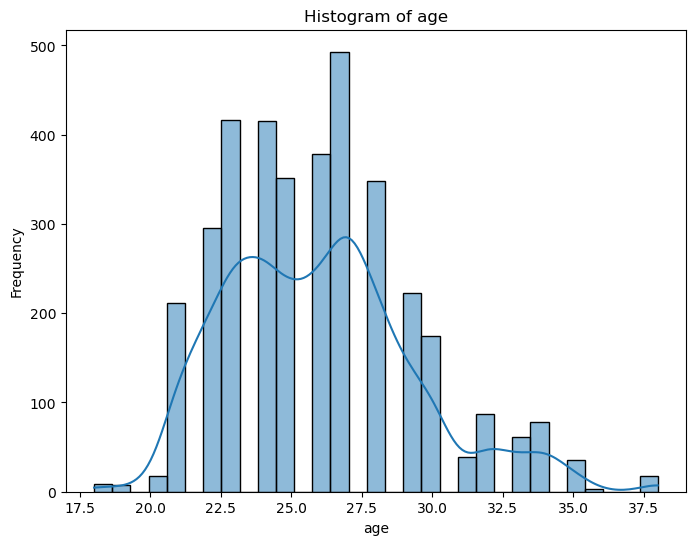

In [82]:
# R: one-variable: plot distribution
# histogram for numeric variable (reference: kaggle example)
# pie chart for categorical variable (reference: discussion example)

numerical_variable = 'age'

plt.figure(figsize=(8, 6))
sns.histplot(data=dating_df, x=numerical_variable, kde=True)
plt.title(f'Histogram of {numerical_variable}')
plt.xlabel(numerical_variable)
plt.ylabel('Frequency')
plt.show()

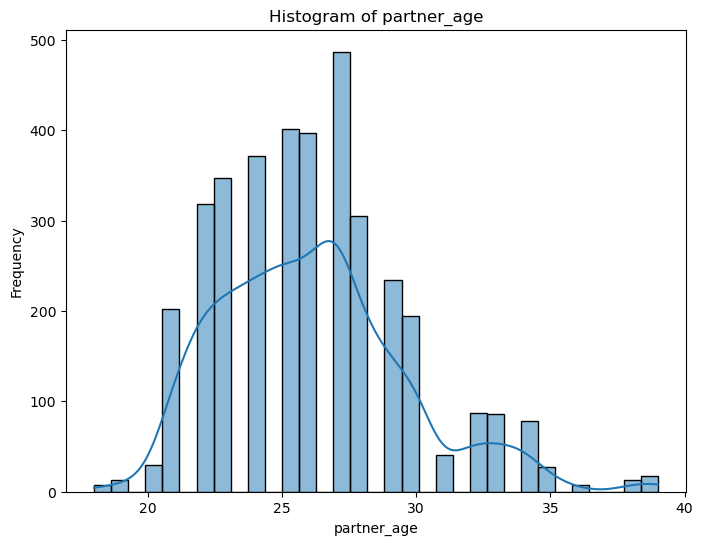

In [55]:
variable = 'partner_age'

plt.figure(figsize=(8, 6))
sns.histplot(dating_df[variable], kde=True)
plt.title(f'Histogram of {variable}')
plt.xlabel(variable)
plt.ylabel('Frequency')
plt.show()

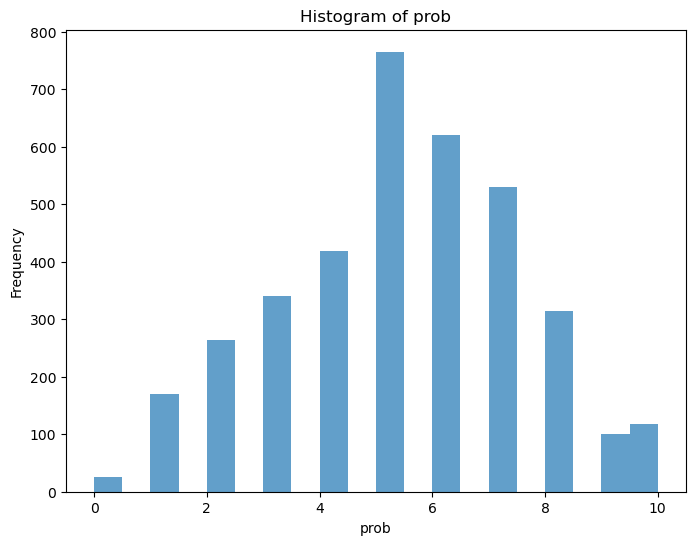

In [63]:
variable = 'prob'

plt.figure(figsize=(8, 6))
plt.hist(dating_df[variable].dropna(), bins=20,alpha=0.7)
plt.title(f'Histogram of {variable}')
plt.xlabel(variable)
plt.ylabel('Frequency')
plt.show()


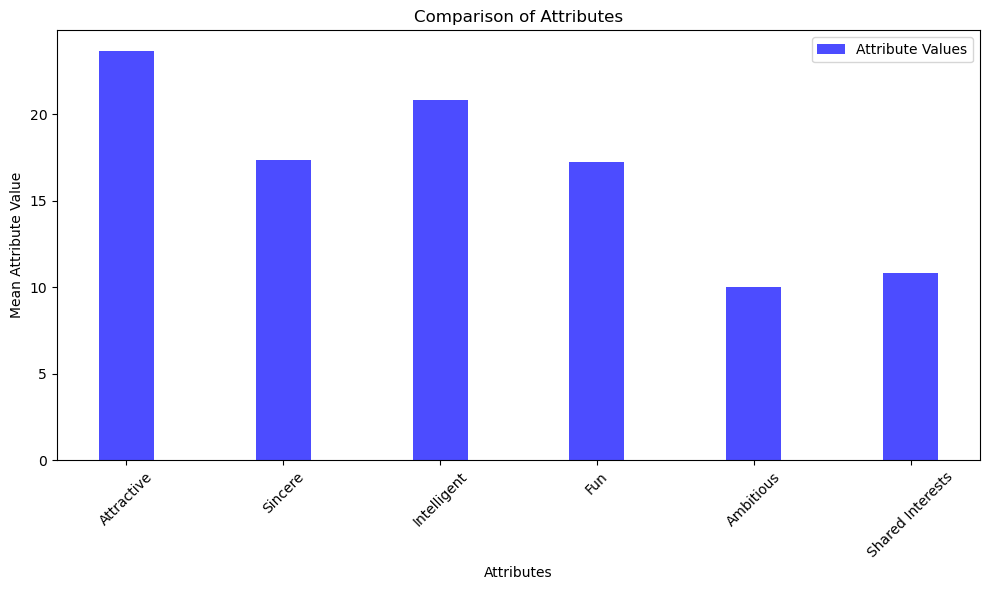

In [73]:
columns_to_plot = ["attr1_1", "sinc1_1", "intel1_1", "fun1_1", "amb1_1", "shar1_1"]
labels = ["Attractive", "Sincere", "Intelligent", "Fun", "Ambitious", "Shared Interests"]

attribute_values = [dating_df[column].mean() for column in columns_to_plot]

x = np.arange(len(labels))

plt.figure(figsize=(10, 6))
plt.bar(x, attribute_values, width=0.35, align='center', alpha=0.7, color='b', label='Attribute Values')

plt.xlabel('Attributes')
plt.xticks(x, labels, rotation=45)

plt.title('Comparison of Attributes')
plt.ylabel('Mean Attribute Value')

plt.legend()

plt.tight_layout()
plt.show()


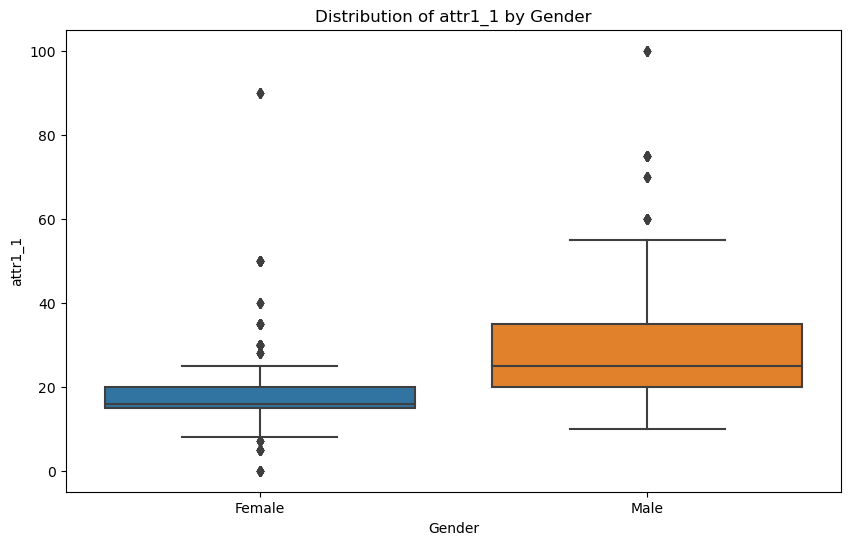

In [58]:
attribute = 'attr1_1'

female_data = dating_df[dating_df['gender'] == 0]
male_data = dating_df[dating_df['gender'] == 1]

plt.figure(figsize=(10, 6))
sns.boxplot(x='gender', y=attribute, data=dating_df)
plt.title(f'Distribution of {attribute} by Gender')
plt.xticks([0, 1], ['Female', 'Male'])
plt.xlabel('Gender')
plt.ylabel(attribute)
plt.show()


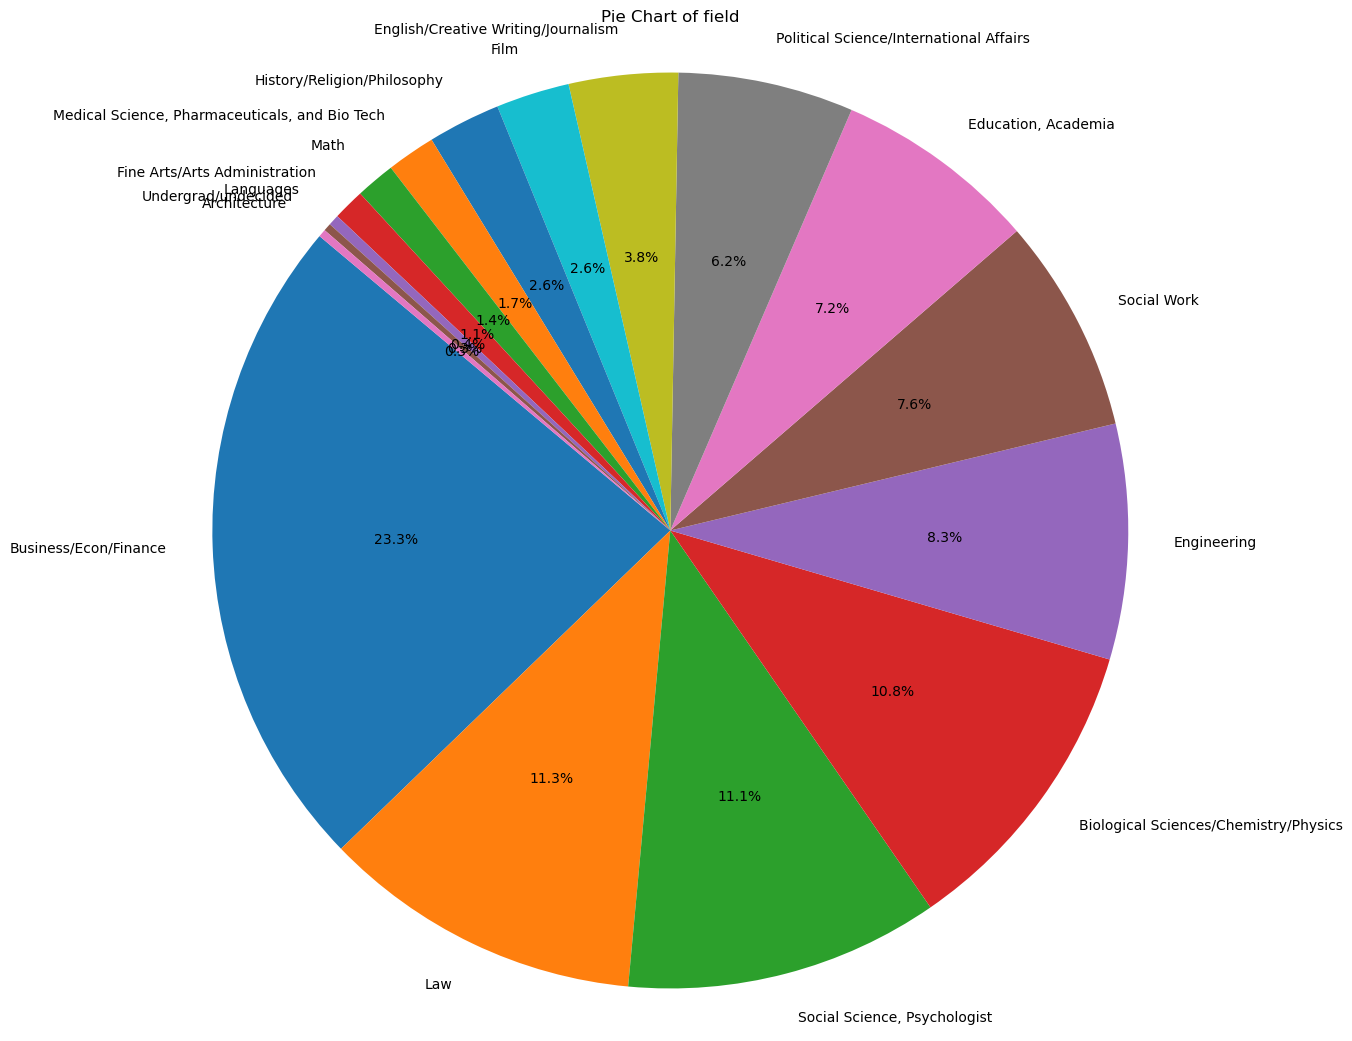

In [72]:
categorical_variable = 'field'
value_counts = dating_df[categorical_variable].value_counts()

plt.figure(figsize=(13, 13))
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal') 
plt.title(f'Pie Chart of {categorical_variable}')
plt.show()


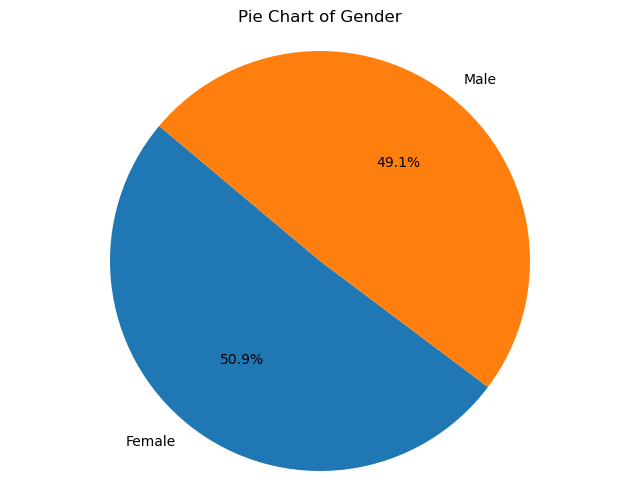

In [51]:
gender_counts = dating_df['gender'].value_counts()

plt.figure(figsize=(8, 6))
plt.pie(gender_counts, labels=['Female', 'Male'], autopct='%1.1f%%', startangle=140)
plt.axis('equal')  
plt.title('Pie Chart of Gender')
plt.show()

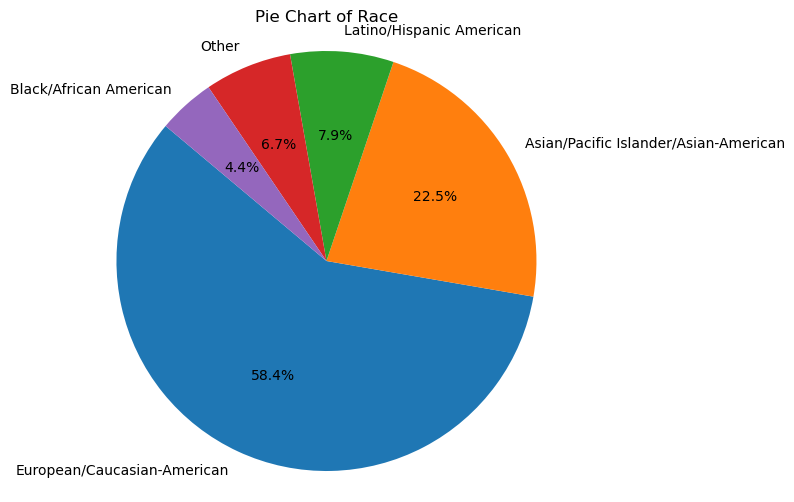

In [56]:
race_mapping = {
    1: "Black/African American",
    2: "European/Caucasian-American",
    3: "Latino/Hispanic American",
    4: "Asian/Pacific Islander/Asian-American",
    5: "Native American",
    6: "Other"
}

dating_df['race'] = dating_df['race'].map(race_mapping)

race_counts = dating_df['race'].value_counts()

plt.figure(figsize=(8, 6))
plt.pie(race_counts, labels=race_counts.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  
plt.title('Pie Chart of Race')
plt.show()


In [38]:
# F: two variable
# change over Time1, during event, Time 2, Time 3
# correlation